In [1]:
import pandas as pd
import numpy as np
 
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from seaborn.linearmodels import *

import xgboost as xgb

from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) 

path = './data/'
train_file = path + 'train.csv'
test_file = path + 'test.csv'

In [2]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file) 
train_df.head()
train_df.shape[0]

train_df = train_df[:train_df.shape[0]]
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_df.drop(train_df[train_df["GrLivArea"] > 4000].index, inplace=True)

test_df.loc[666, "GarageQual"] = "TA"
test_df.loc[666, "GarageCond"] = "TA"
test_df.loc[666, "GarageFinish"] = "Unf"
test_df.loc[666, "GarageYrBlt"] = "1980"

test_df.loc[1116, "GarageType"] = np.nan

lot_frontage_by_neighborhood = train_df["LotFrontage"].groupby(train_df["Neighborhood"])

# Used to convert categorical features into ordinal numbers.
# (There's probably an easier way to do this, but it works.)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

# Combine all the (numerical) features into one big DataFrame. We don't add 
# the one-hot encoded variables here yet, that happens later on.
def munge(df,df2,switch):
    all_df = pd.DataFrame(index = df.index)
   
    all_df["LotFrontage"] = df["LotFrontage"]   
    for key, group in lot_frontage_by_neighborhood:
        idx = (df["Neighborhood"] == key) & (df["LotFrontage"].isnull())
        all_df.loc[idx, "LotFrontage"] = group.median()    

    all_df["LotArea"] = df["LotArea"]

    all_df["MasVnrArea"] = df["MasVnrArea"]
    all_df["MasVnrArea"].fillna(0, inplace=True)
   
    all_df["BsmtFinSF1"] = df["BsmtFinSF1"]
    all_df["BsmtFinSF1"].fillna(0, inplace=True)

    all_df["BsmtFinSF2"] = df["BsmtFinSF2"]
    all_df["BsmtFinSF2"].fillna(0, inplace=True)

    all_df["BsmtUnfSF"] = df["BsmtUnfSF"]
    all_df["BsmtUnfSF"].fillna(0, inplace=True)

    all_df["TotalBsmtSF"] = df["TotalBsmtSF"]
    all_df["TotalBsmtSF"].fillna(0, inplace=True)

    all_df["1stFlrSF"] = df["1stFlrSF"]
    all_df["2ndFlrSF"] = df["2ndFlrSF"]
    all_df["GrLivArea"] = df["GrLivArea"]
    
    all_df["GarageArea"] = df["GarageArea"]
    all_df["GarageArea"].fillna(0, inplace=True)

    all_df["WoodDeckSF"] = df["WoodDeckSF"]
    all_df["OpenPorchSF"] = df["OpenPorchSF"]
    all_df["EnclosedPorch"] = df["EnclosedPorch"]
    all_df["3SsnPorch"] = df["3SsnPorch"]
    all_df["ScreenPorch"] = df["ScreenPorch"]
    
    all_df["BsmtFullBath"] = df["BsmtFullBath"]
    all_df["BsmtFullBath"].fillna(0, inplace=True)

    all_df["BsmtHalfBath"] = df["BsmtHalfBath"]
    all_df["BsmtHalfBath"].fillna(0, inplace=True)

    all_df["FullBath"] = df["FullBath"] 
    all_df["HalfBath"] = df["HalfBath"] 
    all_df["BedroomAbvGr"] = df["BedroomAbvGr"] 
    all_df["KitchenAbvGr"] = df["KitchenAbvGr"] 
    all_df["TotRmsAbvGrd"] = df["TotRmsAbvGrd"] 
    all_df["Fireplaces"] = df["Fireplaces"] 

    all_df["GarageCars"] = df["GarageCars"]
    all_df["GarageCars"].fillna(0, inplace=True)

    all_df["CentralAir"] = (df["CentralAir"] == "Y") * 1.0
   
    all_df["OverallQual"] = df["OverallQual"]
    all_df["OverallCond"] = df["OverallCond"]

    # Quality measurements are stored as text but we can convert them to 
    # numbers where a higher number means higher quality.

    qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    all_df["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)
    all_df["ExterCond"] = df["ExterCond"].map(qual_dict).astype(int)
    all_df["BsmtQual"] = df["BsmtQual"].map(qual_dict).astype(int)
    all_df["BsmtCond"] = df["BsmtCond"].map(qual_dict).astype(int)
    all_df["HeatingQC"] = df["HeatingQC"].map(qual_dict).astype(int)
    all_df["KitchenQual"] = df["KitchenQual"].map(qual_dict).astype(int)
    all_df["FireplaceQu"] = df["FireplaceQu"].map(qual_dict).astype(int)
    all_df["GarageQual"] = df["GarageQual"].map(qual_dict).astype(int)
    all_df["GarageCond"] = df["GarageCond"].map(qual_dict).astype(int)

    all_df["BsmtExposure"] = df["BsmtExposure"].map(
        {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

    bsmt_fin_dict = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    all_df["BsmtFinType1"] = df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
    all_df["BsmtFinType2"] = df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

    all_df["Functional"] = df["Functional"].map(
        {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

    all_df["GarageFinish"] = df["GarageFinish"].map(
        {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

    all_df["Fence"] = df["Fence"].map(
        {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

    all_df["YearBuilt"] = df["YearBuilt"]
    all_df["YearRemodAdd"] = df["YearRemodAdd"]

    all_df["GarageYrBlt"] = df["GarageYrBlt"]
    all_df["GarageYrBlt"].fillna(0.0, inplace=True)

    all_df["MoSold"] = df["MoSold"]
    all_df["YrSold"] = df["YrSold"]
    
    all_df["LowQualFinSF"] = df["LowQualFinSF"]
    all_df["MiscVal"] = df["MiscVal"]

    all_df["PoolQC"] = df["PoolQC"].map(qual_dict).astype(int)

    all_df["PoolArea"] = df["PoolArea"]
    all_df["PoolArea"].fillna(0, inplace=True)
    
    # Add categorical features as numbers too. It seems to help a bit.
    all_df = factorize(df, all_df, "MSSubClass")
    all_df = factorize(df, all_df, "MSZoning", "RL")
    all_df = factorize(df, all_df, "LotConfig")
    all_df = factorize(df, all_df, "Neighborhood")
    all_df = factorize(df, all_df, "Condition1")
    all_df = factorize(df, all_df, "BldgType")
    all_df = factorize(df, all_df, "HouseStyle")
    all_df = factorize(df, all_df, "RoofStyle")
    all_df = factorize(df, all_df, "Exterior1st", "Other")
    all_df = factorize(df, all_df, "Exterior2nd", "Other")
    all_df = factorize(df, all_df, "MasVnrType", "None")
    all_df = factorize(df, all_df, "Foundation")
    all_df = factorize(df, all_df, "SaleType", "Oth")
    all_df = factorize(df, all_df, "SaleCondition")

#     ## groupby  
    
#     if switch == 1:
        
#         all_df["MSSubClass"] = df["MSSubClass"]
#         all_df["MSZoning"] = df["MSZoning"]
#         all_df["LotConfig"] = df["LotConfig"]
#         all_df["Neighborhood"] = df["Neighborhood"]
#         all_df["Condition1"] = df["Condition1"]
#         all_df["BldgType"] = df["BldgType"]
#         all_df["HouseStyle"] = df["HouseStyle"]
#         all_df["RoofStyle"] = df["RoofStyle"]
#         all_df["Exterior1st"] = df["Exterior1st"]
#         all_df["Exterior2nd"] = df["Exterior2nd"]
#         all_df["MasVnrType"] = df["MasVnrType"]
#         all_df["Foundation"] = df["Foundation"]
#         all_df["SaleType"] = df["SaleType"]
#         all_df["SaleCondition"] = df["SaleCondition"] 
     
    
#         df2["MSZoning"].fillna("RL", inplace=True)
#         df2["Exterior1st"].fillna("Other", inplace=True)
#         df2["Exterior2nd"].fillna("Other", inplace=True)
#         df2["MasVnrType"].fillna("None", inplace=True)
#         df2["SaleType"].fillna("Oth", inplace=True)
        
#         grouped1 = df2.groupby(["MSSubClass"])
#         grouped2 = df2.groupby(["MSZoning"])
#         grouped3 = df2.groupby(["LotConfig"])
#         grouped4 = df2.groupby(["Neighborhood"])
#         grouped5 = df2.groupby(["Condition1"])
#         grouped6 = df2.groupby(["BldgType"])
#         grouped7 = df2.groupby(["HouseStyle"])
#         grouped8 = df2.groupby(["RoofStyle"])
#         grouped9 = df2.groupby(["Exterior1st"])
#         grouped10 = df2.groupby(["Exterior2nd"])
#         grouped11 = df2.groupby(["MasVnrType"])
#         grouped12 = df2.groupby(["Foundation"])
#         grouped13 = df2.groupby(["SaleType"])
#         grouped14 = df2.groupby(["SaleCondition"])

#         bin_cate1 = pd.DataFrame({'f1': grouped1['SalePrice'].mean().round(decimals=2)})
#         bin_cate2 = pd.DataFrame({'f2': grouped2['SalePrice'].mean().round(decimals=2)})
#         bin_cate3 = pd.DataFrame({'f3': grouped3['SalePrice'].mean().round(decimals=2)})
#         bin_cate4 = pd.DataFrame({'f4': grouped4['SalePrice'].mean().round(decimals=2)})
#         bin_cate5 = pd.DataFrame({'f5': grouped5['SalePrice'].mean().round(decimals=2)})
#         bin_cate6 = pd.DataFrame({'f6': grouped6['SalePrice'].mean().round(decimals=2)})
#         bin_cate7 = pd.DataFrame({'f7': grouped7['SalePrice'].mean().round(decimals=2)})
#         bin_cate8 = pd.DataFrame({'f8': grouped8['SalePrice'].mean().round(decimals=2)})
#         bin_cate9 = pd.DataFrame({'f9': grouped9['SalePrice'].mean().round(decimals=2)})
#         bin_cate10 = pd.DataFrame({'f10': grouped10['SalePrice'].mean().round(decimals=2)}) 
#         bin_cate11 = pd.DataFrame({'f11': grouped11['SalePrice'].mean().round(decimals=2)})
#         bin_cate12 = pd.DataFrame({'f12': grouped12['SalePrice'].mean().round(decimals=2)})
#         bin_cate13 = pd.DataFrame({'f13': grouped13['SalePrice'].mean().round(decimals=2)})
#         bin_cate14 = pd.DataFrame({'f14': grouped14['SalePrice'].mean().round(decimals=2)})

#         del grouped1, grouped2, grouped3
#         gc.collect()

#         all_df = all_df.merge(bin_cate1,left_on="MSSubClass",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate2,left_on="MSZoning",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate3,left_on="LotConfig",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate4,left_on="Neighborhood",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate5,left_on="Condition1",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate6,left_on="BldgType",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate7,left_on="HouseStyle",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate8,left_on="RoofStyle",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate9,left_on="Exterior1st",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate10,left_on="Exterior2nd",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate11,left_on="MasVnrType",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate12,left_on="Foundation",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate13,left_on="SaleType",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate14,left_on="SaleCondition",how='left',right_index=True)

# #         test_df = test_df.merge(bin_cate1,left_on="MSSubClass",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate2,left_on="MSZoning",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate3,left_on="LotConfig",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate4,left_on="Neighborhood",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate5,left_on="Condition1",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate6,left_on="BldgType",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate7,left_on="HouseStyle",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate8,left_on="RoofStyle",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate9,left_on="Exterior1st",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate10,left_on="Exterior2nd",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate11,left_on="MasVnrType",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate12,left_on="Foundation",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate13,left_on="SaleType",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate14,left_on="SaleCondition",how='left',right_index=True)
        
#     else:    
        
#         all_df["MSSubClass"] = df["MSSubClass"]
#         all_df["MSZoning"] = df["MSZoning"]
#         all_df["LotConfig"] = df["LotConfig"]
#         all_df["Neighborhood"] = df["Neighborhood"]
#         all_df["Condition1"] = df["Condition1"]
#         all_df["BldgType"] = df["BldgType"]
#         all_df["HouseStyle"] = df["HouseStyle"]
#         all_df["RoofStyle"] = df["RoofStyle"]
#         all_df["Exterior1st"] = df["Exterior1st"]
#         all_df["Exterior2nd"] = df["Exterior2nd"]
#         all_df["MasVnrType"] = df["MasVnrType"]
#         all_df["Foundation"] = df["Foundation"]
#         all_df["SaleType"] = df["SaleType"]
#         all_df["SaleCondition"] = df["SaleCondition"]
#         all_df['SalePrice'] = df['SalePrice']
     
    
#         all_df["MSZoning"].fillna("RL", inplace=True)
#         all_df["Exterior1st"].fillna("Other", inplace=True)
#         all_df["Exterior2nd"].fillna("Other", inplace=True)
#         all_df["MasVnrType"].fillna("None", inplace=True)
#         all_df["SaleType"].fillna("Oth", inplace=True)
        
#         grouped1 = all_df.groupby(["MSSubClass"])
#         grouped2 = all_df.groupby(["MSZoning"])
#         grouped3 = all_df.groupby(["LotConfig"])
#         grouped4 = all_df.groupby(["Neighborhood"])
#         grouped5 = all_df.groupby(["Condition1"])
#         grouped6 = all_df.groupby(["BldgType"])
#         grouped7 = all_df.groupby(["HouseStyle"])
#         grouped8 = all_df.groupby(["RoofStyle"])
#         grouped9 = all_df.groupby(["Exterior1st"])
#         grouped10 = all_df.groupby(["Exterior2nd"])
#         grouped11 = all_df.groupby(["MasVnrType"])
#         grouped12 = all_df.groupby(["Foundation"])
#         grouped13 = all_df.groupby(["SaleType"])
#         grouped14 = all_df.groupby(["SaleCondition"])

#         bin_cate1 = pd.DataFrame({'f1': grouped1['SalePrice'].mean().round(decimals=2)})
#         bin_cate2 = pd.DataFrame({'f2': grouped2['SalePrice'].mean().round(decimals=2)})
#         bin_cate3 = pd.DataFrame({'f3': grouped3['SalePrice'].mean().round(decimals=2)})
#         bin_cate4 = pd.DataFrame({'f4': grouped4['SalePrice'].mean().round(decimals=2)})
#         bin_cate5 = pd.DataFrame({'f5': grouped5['SalePrice'].mean().round(decimals=2)})
#         bin_cate6 = pd.DataFrame({'f6': grouped6['SalePrice'].mean().round(decimals=2)})
#         bin_cate7 = pd.DataFrame({'f7': grouped7['SalePrice'].mean().round(decimals=2)})
#         bin_cate8 = pd.DataFrame({'f8': grouped8['SalePrice'].mean().round(decimals=2)})
#         bin_cate9 = pd.DataFrame({'f9': grouped9['SalePrice'].mean().round(decimals=2)})
#         bin_cate10 = pd.DataFrame({'f10': grouped10['SalePrice'].mean().round(decimals=2)}) 
#         bin_cate11 = pd.DataFrame({'f11': grouped11['SalePrice'].mean().round(decimals=2)})
#         bin_cate12 = pd.DataFrame({'f12': grouped12['SalePrice'].mean().round(decimals=2)})
#         bin_cate13 = pd.DataFrame({'f13': grouped13['SalePrice'].mean().round(decimals=2)})
#         bin_cate14 = pd.DataFrame({'f14': grouped14['SalePrice'].mean().round(decimals=2)})

#         del grouped1, grouped2, grouped3
#         gc.collect()

#         all_df = all_df.merge(bin_cate1,left_on="MSSubClass",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate2,left_on="MSZoning",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate3,left_on="LotConfig",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate4,left_on="Neighborhood",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate5,left_on="Condition1",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate6,left_on="BldgType",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate7,left_on="HouseStyle",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate8,left_on="RoofStyle",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate9,left_on="Exterior1st",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate10,left_on="Exterior2nd",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate11,left_on="MasVnrType",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate12,left_on="Foundation",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate13,left_on="SaleType",how='left',right_index=True)
#         all_df = all_df.merge(bin_cate14,left_on="SaleCondition",how='left',right_index=True)

# #         test_df = test_df.merge(bin_cate1,left_on="MSSubClass",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate2,left_on="MSZoning",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate3,left_on="LotConfig",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate4,left_on="Neighborhood",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate5,left_on="Condition1",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate6,left_on="BldgType",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate7,left_on="HouseStyle",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate8,left_on="RoofStyle",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate9,left_on="Exterior1st",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate10,left_on="Exterior2nd",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate11,left_on="MasVnrType",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate12,left_on="Foundation",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate13,left_on="SaleType",how='left',right_index=True)
# #         test_df = test_df.merge(bin_cate14,left_on="SaleCondition",how='left',right_index=True)
     
    # IR2 and IR3 don't appear that often, so just make a distinction
    # between regular and irregular.
    all_df["IsRegularLotShape"] = (df["LotShape"] == "Reg") * 1

    # Most properties are level; bin the other possibilities together
    # as "not level".
    all_df["IsLandLevel"] = (df["LandContour"] == "Lvl") * 1

    # Most land slopes are gentle; treat the others as "not gentle".
    all_df["IsLandSlopeGentle"] = (df["LandSlope"] == "Gtl") * 1

    # Most properties use standard circuit breakers.
    all_df["IsElectricalSBrkr"] = (df["Electrical"] == "SBrkr") * 1

    # About 2/3rd have an attached garage.
    all_df["IsGarageDetached"] = (df["GarageType"] == "Detchd") * 1

    # Most have a paved drive. Treat dirt/gravel and partial pavement
    # as "not paved".
    all_df["IsPavedDrive"] = (df["PavedDrive"] == "Y") * 1

    # The only interesting "misc. feature" is the presence of a shed.
    all_df["HasShed"] = (df["MiscFeature"] == "Shed") * 1.  

    # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
    all_df["Remodeled"] = (all_df["YearRemodAdd"] != all_df["YearBuilt"]) * 1
    
    # Did a remodeling happen in the year the house was sold?
    all_df["RecentRemodel"] = (all_df["YearRemodAdd"] == all_df["YrSold"]) * 1
    
    # Was this house sold in the year it was built?
    all_df["VeryNewHouse"] = (all_df["YearBuilt"] == all_df["YrSold"]) * 1

    all_df["Has2ndFloor"] = (all_df["2ndFlrSF"] == 0) * 1
    all_df["HasMasVnr"] = (all_df["MasVnrArea"] == 0) * 1
    all_df["HasWoodDeck"] = (all_df["WoodDeckSF"] == 0) * 1
    all_df["HasOpenPorch"] = (all_df["OpenPorchSF"] == 0) * 1
    all_df["HasEnclosedPorch"] = (all_df["EnclosedPorch"] == 0) * 1
    all_df["Has3SsnPorch"] = (all_df["3SsnPorch"] == 0) * 1
    all_df["HasScreenPorch"] = (all_df["ScreenPorch"] == 0) * 1

    # These features actually lower the score a little.
    # all_df["HasBasement"] = df["BsmtQual"].isnull() * 1
    # all_df["HasGarage"] = df["GarageQual"].isnull() * 1
    # all_df["HasFireplace"] = df["FireplaceQu"].isnull() * 1
    # all_df["HasFence"] = df["Fence"].isnull() * 1

    # Months with the largest number of deals may be significant.
    all_df["HighSeason"] = df["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    all_df["NewerDwelling"] = df["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
    all_df.loc[df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
    all_df["Neighborhood_Good"].fillna(0, inplace=True)

    all_df["SaleCondition_PriceDown"] = df.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

    # House completed before sale or not
    all_df["BoughtOffPlan"] = df.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    all_df["BadHeating"] = df.HeatingQC.replace(
        {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    all_df["TotalArea"] = all_df[area_cols].sum(axis=1)

    all_df["TotalArea1st2nd"] = all_df["1stFlrSF"] + all_df["2ndFlrSF"]

    all_df["Age"] = 2010 - all_df["YearBuilt"]
    all_df["TimeSinceSold"] = 2010 - all_df["YrSold"]

    all_df["SeasonSold"] = all_df["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
    all_df["YearsSinceRemodel"] = all_df["YrSold"] - all_df["YearRemodAdd"]
    
    # Simplifications of existing features into bad/average/good.
    all_df["SimplOverallQual"] = all_df.OverallQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplOverallCond"] = all_df.OverallCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplPoolQC"] = all_df.PoolQC.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2})
    all_df["SimplGarageCond"] = all_df.GarageCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplGarageQual"] = all_df.GarageQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFunctional"] = all_df.Functional.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    all_df["SimplKitchenQual"] = all_df.KitchenQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplHeatingQC"] = all_df.HeatingQC.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtFinType1"] = all_df.BsmtFinType1.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtFinType2"] = all_df.BsmtFinType2.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtCond"] = all_df.BsmtCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtQual"] = all_df.BsmtQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterCond"] = all_df.ExterCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterQual"] = all_df.ExterQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
            
    # Bin by neighborhood (a little arbitrarily). Values were computed by: 
    # train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
    neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

    all_df["NeighborhoodBin"] = df["Neighborhood"].map(neighborhood_map)
    return all_df

train_df_munged = munge(train_df,train_df,0)
test_df_munged = munge(test_df,train_df,1)

print(train_df_munged.shape)
print(test_df_munged.shape)

# Copy NeighborhoodBin into a temporary DataFrame because we want to use the
# unscaled version later on (to one-hot encode it). 
neighborhood_bin_train = pd.DataFrame(index = train_df.index)
neighborhood_bin_train["NeighborhoodBin"] = train_df_munged["NeighborhoodBin"]
neighborhood_bin_test = pd.DataFrame(index = test_df.index)
neighborhood_bin_test["NeighborhoodBin"] = test_df_munged["NeighborhoodBin"]

################################################################################

numeric_features = train_df_munged.dtypes[train_df_munged.dtypes != "object"].index

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = train_df_munged[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

train_df_munged[skewed] = np.log1p(train_df_munged[skewed])
test_df_munged[skewed] = np.log1p(test_df_munged[skewed])

# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df_munged[numeric_features])

scaled = scaler.transform(train_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    train_df_munged[col] = scaled[:, i]

scaled = scaler.transform(test_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    test_df_munged[col] = scaled[:, i]

################################################################################

# Convert categorical features using one-hot encoding.
def onehot(onehot_df, df, column_name, fill_na, drop_name):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_df[column_name], prefix="_" + column_name)
    
    # Dropping one of the columns actually made the results slightly worse.
    # if drop_name is not None:
    #     dummies.drop(["_" + column_name + "_" + drop_name], axis=1, inplace=True)

    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

def munge_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)

    onehot_df = onehot(onehot_df, df, "MSSubClass", None, "40")
    onehot_df = onehot(onehot_df, df, "MSZoning", "RL", "RH")
    onehot_df = onehot(onehot_df, df, "LotConfig", None, "FR3")
    onehot_df = onehot(onehot_df, df, "Neighborhood", None, "OldTown")
    onehot_df = onehot(onehot_df, df, "Condition1", None, "RRNe")
    onehot_df = onehot(onehot_df, df, "BldgType", None, "2fmCon")
    onehot_df = onehot(onehot_df, df, "HouseStyle", None, "1.5Unf")
    onehot_df = onehot(onehot_df, df, "RoofStyle", None, "Shed")
    onehot_df = onehot(onehot_df, df, "Exterior1st", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Exterior2nd", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Foundation", None, "Wood")
    onehot_df = onehot(onehot_df, df, "SaleType", "WD", "Oth")
    onehot_df = onehot(onehot_df, df, "SaleCondition", "Normal", "AdjLand")

    # Fill in missing MasVnrType for rows that do have a MasVnrArea.
    temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
    idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
    temp_df.loc[idx, "MasVnrType"] = "BrkFace"
    onehot_df = onehot(onehot_df, temp_df, "MasVnrType", "None", "BrkCmn")

    # Also add the booleans from calc_df as dummy variables.
    onehot_df = onehot(onehot_df, df, "LotShape", None, "IR3")
    onehot_df = onehot(onehot_df, df, "LandContour", None, "Low")
    onehot_df = onehot(onehot_df, df, "LandSlope", None, "Sev")
    onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr", "FuseP")
    onehot_df = onehot(onehot_df, df, "GarageType", "None", "CarPort")
    onehot_df = onehot(onehot_df, df, "PavedDrive", None, "P")
    onehot_df = onehot(onehot_df, df, "MiscFeature", "None", "Othr")

    # Features we can probably ignore (but want to include anyway to see
    # if they make any positive difference).
    # Definitely ignoring Utilities: all records are "AllPub", except for
    # one "NoSeWa" in the train set and 2 NA in the test set.
    onehot_df = onehot(onehot_df, df, "Street", None, "Grvl")
    onehot_df = onehot(onehot_df, df, "Alley", "None", "Grvl")
    onehot_df = onehot(onehot_df, df, "Condition2", None, "PosA")
    onehot_df = onehot(onehot_df, df, "RoofMatl", None, "WdShake")
    onehot_df = onehot(onehot_df, df, "Heating", None, "Wall")

    # I have these as numerical variables too.
    onehot_df = onehot(onehot_df, df, "ExterQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "ExterCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "HeatingQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "KitchenQual", "TA", "Ex")
    onehot_df = onehot(onehot_df, df, "FireplaceQu", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "PoolQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtExposure", "None", "Gd")
    onehot_df = onehot(onehot_df, df, "BsmtFinType1", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "BsmtFinType2", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "Functional", "Typ", "Typ")
    onehot_df = onehot(onehot_df, df, "GarageFinish", "None", "Fin")
    onehot_df = onehot(onehot_df, df, "Fence", "None", "MnPrv")
    onehot_df = onehot(onehot_df, df, "MoSold", None, None)
    
    # Divide up the years between 1871 and 2010 in slices of 20 years.
    year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
    yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)

    yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
    yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)
    
    onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearBuiltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearRemodAddBin", None, None)

    return onehot_df

# Add the one-hot encoded categorical features.
onehot_df = munge_onehot(train_df)
onehot_df = onehot(onehot_df, neighborhood_bin_train, "NeighborhoodBin", None, None)
train_df_munged = train_df_munged.join(onehot_df)

# These onehot columns are missing in the test data, so drop them from the
# training data or we might overfit on them.
drop_cols = [
                "_Exterior1st_ImStucc", "_Exterior1st_Stone",
                "_Exterior2nd_Other","_HouseStyle_2.5Fin", 
            
                "_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll",
                "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn",
                "_Heating_Floor", "_Heating_OthW",

                "_Electrical_Mix", 
                "_MiscFeature_TenC",
                "_GarageQual_Ex", "_PoolQC_Fa"
            ]
train_df_munged.drop(drop_cols, axis=1, inplace=True)

onehot_df = munge_onehot(test_df)
onehot_df = onehot(onehot_df, neighborhood_bin_test, "NeighborhoodBin", None, None)
test_df_munged = test_df_munged.join(onehot_df)

# This column is missing in the training data. There is only one example with
# this value in the test set. So just drop it.
test_df_munged.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns. They are either not very helpful or they cause overfitting.
drop_cols = [
    "_Condition2_PosN",    # only two are not zero
    "_MSZoning_C (all)",
    "_MSSubClass_160",
]
train_df_munged.drop(drop_cols, axis=1, inplace=True)
test_df_munged.drop(drop_cols, axis=1, inplace=True)

################################################################################

# We take the log here because the error metric is between the log of the
# SalePrice and the log of the predicted price. That does mean we need to 
# exp() the prediction to get an actual sale price.
label_df = pd.DataFrame(index = train_df_munged.index, columns=["SalePrice"])
label_df["SalePrice"] = np.log(train_df["SalePrice"])

print("Training set size:", train_df_munged.shape)
print("Test set size:", test_df_munged.shape)

(1456, 111)
(1459, 111)
('Training set size:', (1456, 403))
('Test set size:', (1459, 403))


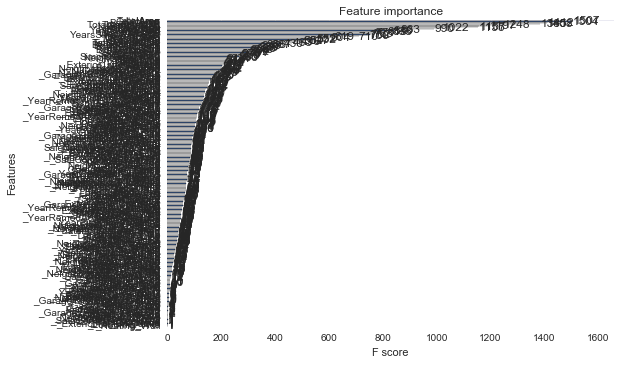

In [4]:
# XGBoost -- I did some "manual" cross-validation here but should really find
# these hyperparameters using CV. ;-)

from xgboost import plot_importance
from matplotlib import pyplot

xgb_regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

xgb_regr.fit(train_df_munged, label_df)

plot_importance(xgb_regr)
pyplot.show()

## This looks like we can drop many features!

In [ ]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

y_train_pred_xgb = xgb_regr.predict(train_df_munged)
y_test = label_df
print("XGBoost score on training set: ", rmse(y_test, y_train_pred_xgb))

# Fit model using each importance as a threshold
#thresholds = sort(xgb_regr.feature_importances_)
# thresholds = sort([0.1,0.2])
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(xgb_regr, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(train_df_munged)
#     # train model
#     selection_model = xgb.XGBRegressor(
#                      colsample_bytree=0.2,
#                      gamma=0.0,
#                      learning_rate=0.01,
#                      max_depth=4,
#                      min_child_weight=1.5,
#                      n_estimators=7200,                                                                  
#                      reg_alpha=0.9,
#                      reg_lambda=0.6,
#                      subsample=0.2,
#                      seed=42,
#                      silent=1) 
#     selection_model.fit(select_X_train, y_test)
#     # eval model
#     select_X_test = selection.transform(train_df_munged)
    
#     y_pred = selection_model.predict(select_X_test)
#     print("Thresh=%.3f, n=%d, RMSE= %.10f" % (thresh, select_X_train.shape[1], rmse(y_test, y_pred)))

# # Run prediction on training set to get a rough idea of how well it does.
# y_train_pred_xgb = xgb_regr.predict(train_df_munged)
# y_test = label_df
# print("XGBoost score on training set: ", rmse(y_test, y_train_pred_xgb))

# Run prediction on the Kaggle test set.
y_test_pred_xgb = xgb_regr.predict(test_df_munged)

In [ ]:
# ## Xgboost gridsearch
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import r2_score

# xtreme_forest = xgb.XGBRegressor()

# parameter_grid = {'max_depth' : [4,5,6],
#                  'n_estimators':[100]
#                  #'n_estimators': [200,210,240,250],
#                  #'min_child_weight': [1,2,3,4]
#                  }

# cross_validation = StratifiedKFold(np.array(label_df['SalePrice']), n_folds=5)

# grid_search_xgboost = GridSearchCV(xtreme_forest,
#                            param_grid = parameter_grid,
#                            scoring = 'mean_squared_error',
#                            cv = cross_validation)

# grid_search_xgboost.fit(train_df_munged, label_df)

# print('Best score (Xgboost): {}'.format(grid_search_xgboost.best_score_))
# print('Best parameters: {}'.format(grid_search_xgboost.best_params_))

In [ ]:
from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.00099

lasso_regr = Lasso(alpha=best_alpha, max_iter=50000)
lasso_regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_train_pred_lasso = lasso_regr.predict(train_df_munged)
y_test = label_df
print("Lasso score on training set: ", rmse(y_test, y_train_pred_lasso))

# Run prediction on the Kaggle test set.
y_test_pred_lasso = lasso_regr.predict(test_df_munged)

In [ ]:
# Kernel Ridge GridSearch
from sklearn.kernel_ridge import KernelRidge
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import r2_score

kridge_grid = KernelRidge()

parameter_grid = {'alpha': [0.0001,0.001,0.01,0.1],
                 'degree': [1,2,3,4],
                 'kernel': ['polynomial']
                 #'n_estimators': [200,210,240,250],
                 #'min_child_weight': [1,2,3,4]
                 }

cross_validation = StratifiedKFold(np.array(label_df['SalePrice']), n_folds=10)

grid_search_kridge = GridSearchCV(kridge_grid,
                           param_grid = parameter_grid,
                           scoring = 'mean_squared_error',
                           cv = cross_validation)

grid_search_kridge.fit(train_df_munged, label_df)

print('Best score (Kernel Ridge): {}'.format(grid_search_kridge.best_score_))
print('Best parameters: {}'.format(grid_search_kridge.best_params_))

In [ ]:
y_train_pred_kridge = grid_search_kridge.best_estimator_.predict(train_df_munged)
print("Kernel Ridge score on training set: ", rmse(label_df,y_train_pred_kridge))
y_test_pred_kridge = grid_search_kridge.best_estimator_.predict(test_df_munged)

In [ ]:
# Extra Trees Regressor

et_regr = ExtraTreesRegressor()
et_regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = et_regr.predict(train_df_munged)
y_test = label_df
print("Extra Trees Regressor score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_test_pred_et = et_regr.predict(test_df_munged)

# Fit model using each importance as a threshold
thresholds = sort(et_regr.feature_importances_)
#thresholds = sort([0.1,0.2])
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(et_regr, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train_df_munged)
    # train model
    selection_model = ExtraTreesRegressor()
    selection_model.fit(select_X_train, y_test)
    # eval model
    select_X_test = selection.transform(train_df_munged)
    
    y_pred = selection_model.predict(select_X_test)
    print("Thresh=%.3f, n=%d, RMSE= %.10f" % (thresh, select_X_train.shape[1], rmse(y_test, y_pred)))

In [ ]:
selection = SelectFromModel(et_regr, threshold=0.01, prefit=True)
select_X_train = selection.transform(train_df_munged)
# train model
selection_model = ExtraTreesRegressor()
selection_model.fit(select_X_train, y_test)
# eval model
select_X_test = selection.transform(test_df_munged)

y_test_pred_et_selec = selection_model.predict(select_X_test)

In [ ]:
## Random Forest

rf_regr = RandomForestRegressor(n_estimators=5000, max_depth=8, max_features='sqrt',min_samples_split=20,n_jobs=-1)
rf_regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_train_pred_rf = rf_regr.predict(train_df_munged)
y_test = label_df
print("Random Forest score on training set: ", rmse(y_test, y_train_pred_rf))

# Run prediction on the Kaggle test set.
y_test_pred_rf = rf_regr.predict(test_df_munged)

# Fit model using each importance as a threshold
thresholds = sort(rf_regr.feature_importances_)
#thresholds = sort([0.1,0.2])
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(rf_regr, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train_df_munged)
    # train model
    selection_model = RandomForestRegressor(n_estimators=5000, max_depth=8, max_features='sqrt',min_samples_split=20,n_jobs=-1) 
    selection_model.fit(select_X_train, y_test)
    # eval model
    select_X_test = selection.transform(train_df_munged)
    
    y_pred = selection_model.predict(select_X_test)
    print("Thresh=%.3f, n=%d, RMSE= %.10f" % (thresh, select_X_train.shape[1], rmse(y_test, y_pred)))

In [ ]:
gbm_grid = GradientBoostingRegressor(max_features='sqrt')

parameter_grid = {'max_depth' : [4,6,8],
                 'n_estimators': [5000],
                 'min_samples_split':[5,10,15,20]}

cross_validation = StratifiedKFold(label_df['SalePrice'], n_folds=5)

grid_search_gbm = GridSearchCV(gbm_grid,
                           param_grid = parameter_grid,
                           cv = cross_validation)

grid_search_gbm.fit(train_df_munged, label_df)

print('Best score (GradientBoostingRegressor): {}'.format(grid_search_gbm.best_score_))
print('Best parameters: {}'.format(grid_search_gbm.best_params_))

y_train_pred_gbm = grid_search_gbm.best_estimator_.predict(train_df_munged)
print("GBM score on training set: ", rmse(label_df,y_train_pred_gbm))
y_test_pred_gbm = grid_search_gbm.best_estimator_.predict(test_df_munged)

In [ ]:
#y_final = (1*np.ravel(y_test_pred_xgb) + 1*np.ravel(y_test_pred_kridge) + 1*np.ravel(y_test_pred_lasso))/3
#y_final = 1*np.ravel(y_test_pred_et)
y_final = 1*np.ravel(y_test_pred_et_selec)
y_final.shape

In [ ]:
y_pred = np.exp(y_final)

# Final Conversion.
#output_file = 'xg_ls_rd_feat_selec'
output_file = 'et_selec'
final_file = '0111_'+ output_file +'.csv'

pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.shape
pred_df.to_csv(path+final_file, header=True, index_label='Id')